In [43]:
# Necessary import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import time

import warnings
warnings.filterwarnings("ignore")

# Data Preparation:

In [44]:
# Fetching the MNIST Dataset
mnist = fetch_openml('mnist_784',version=1,as_frame=False)

#The data key contains the features and the target key contains the labels.
X,y = mnist["data"],mnist['target']

In [45]:
def plot_fun(X):
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(X_images[i],cmap='gray')
        plt.title(f'Label:{y[i]}')
    plt.show()

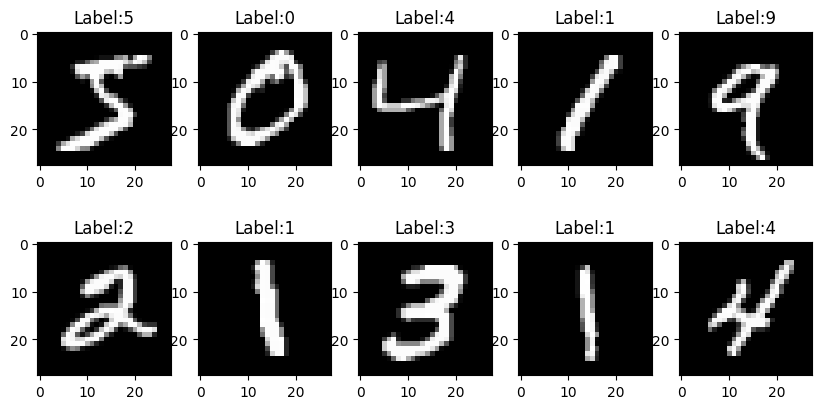

In [46]:
#Plotting the digits.

X_images = X.reshape(-1,28,28)

plot_fun(X_images)

In [47]:
# Printing the shapes of the dataset.
print("The Shape of the features is: ",X.shape)
print("The Shape of the targets is: ",y.shape)

The Shape of the features is:  (70000, 784)
The Shape of the targets is:  (70000,)


In [48]:
# Normalize the images so that pixel values are between 0 and 1.

X = X.astype('float32')/255.0
y = y.astype('int')

In [49]:
# Splitting the data into training and testing data.
# training as 80% and testing as 20%

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("The shape of the training data is: ",X_train.shape)
print("The shape of the training labels is :",y_train.shape)
print("The shape of the testing data is: ",X_test.shape)
print("The shape of the testing labels is :",y_test.shape)

The shape of the training data is:  (56000, 784)
The shape of the training labels is : (56000,)
The shape of the testing data is:  (14000, 784)
The shape of the testing labels is : (14000,)


-In the data preparation step i have import the mnist data set which is in the dataframe form.I have converted it into the numpy array.
-Normalized the data in the pixel from [0,255] to [0,1]
-Plotted the sample first 10 images of the mnist dataset.
-Divided the data in 80% training and 20% testing.

# Implement PCA:

In [51]:
# Apply PCA to reduce the dimensions of the dataset. Initially, choose 50 components for dimensionality reduction.
from sklearn import decomposition

pca = decomposition.PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)

percentage_variation_exp = pca.explained_variance_/np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_variation_exp)

# Adjusting to retain atleast 95% varience
n_components = np.argmax(cum_var_explained >= 0.95) + 1
print("Number of components to retain 95% variance:", n_components)

Number of components to retain 95% variance: 40


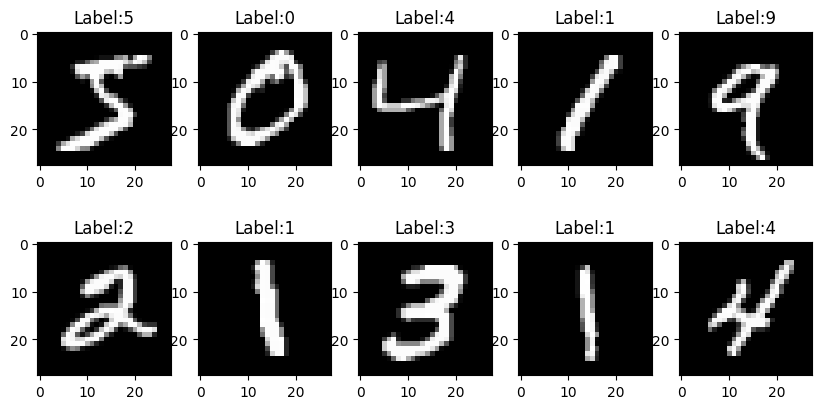

In [52]:
# Checking the images after the dimension reduction.
plot_fun(X_train_pca)

[ 0.49200895 -0.75255084 -0.7960732  ... -3.834478    4.8028054
  3.125842  ] [-2.153535    2.5977545   0.72151124 ... -1.4528804  -1.5621144
 -4.1309457 ]


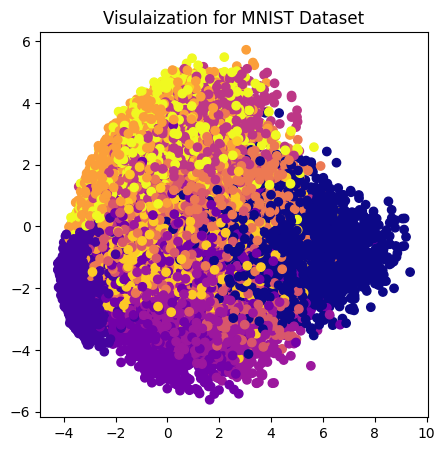

In [53]:
plt.figure(figsize=(5,5))
print(X_train_pca[:,0], X_train_pca[:,1])
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap='plasma')
plt.title("Visulaization for MNIST Dataset")
plt.show()

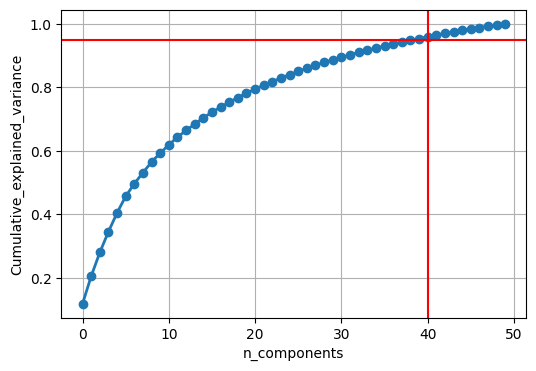

In [54]:
# Show the Scree plot.
plt.figure(1,figsize=(6,4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2, marker='o')
plt.axhline(y=0.95,color='r')
plt.axvline(x=40,color='r')
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In the Principle component analysis.
-We get the covarience matrix for the original data which is (784*784)
-Find the Eigen values and Eigen vectors for the Covarience Matrix.
-Arrange the values and vectors in descending order.
-PCA Function considers only the first 50 components.
-I have plotted the models first few components we can see the datapoints in the 2-D.

-Later finding the Cummulative Variance for the reduced dataset.
-Model Achieved the 95% at the 40 components only Graph shows it all.

# Classification with Logistic Regression

In [55]:
# Importing the libraries required for the Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train the classifier on the original high-dimensional data and evaluate its performance on the test set.
start_time = time.time()
log_reg = LogisticRegression(max_iter=150)
log_reg.fit(X_train,y_train)
end_time = time.time()

y_pred = log_reg.predict(X_test)
acc_original = accuracy_score(y_pred,y_test)
print("Execution time: ",(end_time-start_time))
print("Accuracy Score for the without dimensionality reduction: ", acc_original*100)

Execution time:  42.17752957344055
Accuracy Score for the without dimensionality reduction:  92.08571428571429


In [56]:
# Train the classifier on the PCA-reduced training data and validate its performance using the PCA reduced test data.

# For testing we need to reduce the dimension of the test data same as the train data.
X_test_pca = pca.transform(X_test)

log_reg.fit(X_train_pca,y_train)
y_pred_pca = log_reg.predict(X_test_pca)
acc_reduced = accuracy_score(y_pred_pca,y_test)
print("Accuracy Score for the with dimensionality reduction: ", acc_reduced*100)

Accuracy Score for the with dimensionality reduction:  90.80714285714285


-Original datset have the accuracy of 92.08571428571429 and Reduced dataset has the accuracy of 90.80714285714285
-Original datset have the TimeTaken of 42.1 and Reduced dataset has the Timetaken of 4.247464656829834

# Neural Network Classifier & Performance Evaluation.

In [57]:
# Design a simple neural network for digit classification. The network should have an input layer
# that matches the number of PCA components, at least one hidden layer, and an output layer
# with 10 units (corresponding to the 10-digit classes).
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import precision_score
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

In [58]:
# Function for evaluating the models training and validation loss and accuracy plots.
def graph_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Loss Plot of the Model")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train','test'],loc='upper right')
    plt.show()

In [59]:
def DenseNN(X_train, y_train, X_test, y_test, layer, optimizer, param):

    start_time = time.time()
    #Defining the Model
    model = Sequential([
        Dense(layer[0],activation='relu',input_shape = (param,)),
        Dense(layer[1],activation='relu'),
        Dense(10,activation='softmax')
    ])

    #Compiling the Model with Hyper Parameters.
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    #Summarizing the Model
    #model.summary()

    #Training the Model with the dataset.
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

    #Evaluate the Model and accuracy
    _,acc = model.evaluate(X_test,y_test)
    print("Accuracy of the Model is: ",acc)

    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    precision = precision_score(y_test, y_pred_labels, average= 'macro')
    print("Precision of the Model is: ",precision)


    end_time = time.time()
    print("The time taken for the model execution is :",(end_time-start_time))

    graph_plot(history)

438/438 [==============================] - 1s 2ms/step - loss: 0.0967 - accuracy: 0.9737
Accuracy of the Model is:  0.973714292049408
438/438 [==============================] - 1s 2ms/step
Precision of the Model is:  0.9734959494827132
The time taken for the model execution is : 22.79755926132202


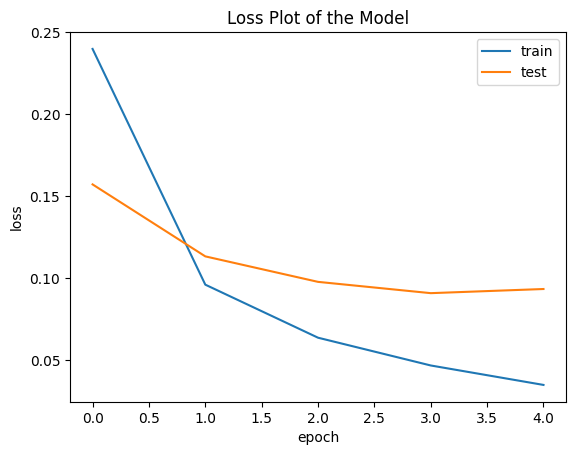

438/438 [==============================] - 1s 2ms/step - loss: 0.1004 - accuracy: 0.9747
Accuracy of the Model is:  0.9747142791748047
438/438 [==============================] - 1s 1ms/step
Precision of the Model is:  0.9745858497909081
The time taken for the model execution is : 22.516774892807007


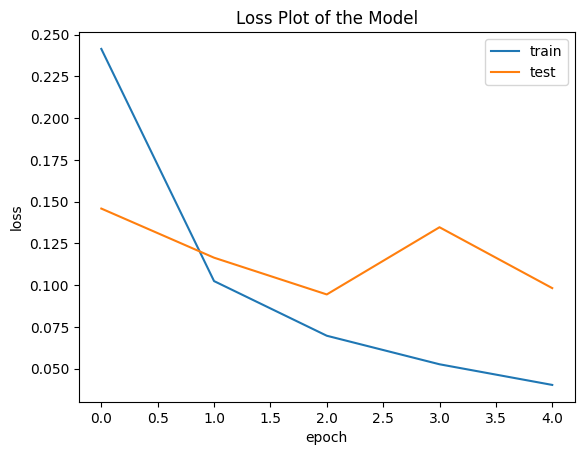

In [60]:
param = 784
num_neurons = [256,64]
for optimizer in [Adam(learning_rate=0.001),RMSprop(learning_rate=0.001)]:
    DenseNN(X_train, y_train, X_test, y_test, num_neurons, optimizer, param)

438/438 [==============================] - 1s 2ms/step - loss: 0.0828 - accuracy: 0.9751
Accuracy of the Model is:  0.9751428365707397
438/438 [==============================] - 1s 2ms/step
Precision of the Model is:  0.9749955176604435
The time taken for the model execution is : 22.67956852912903


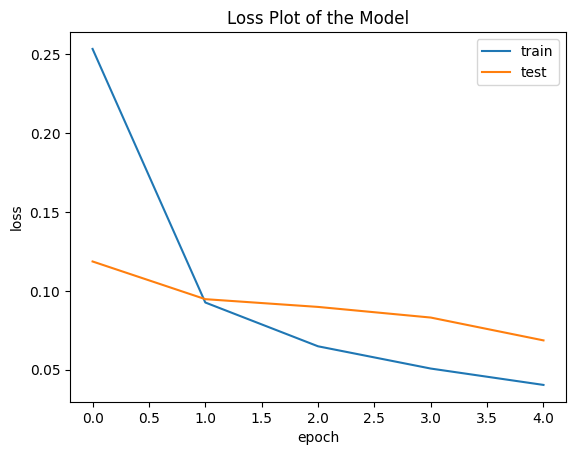

438/438 [==============================] - 1s 2ms/step - loss: 0.0921 - accuracy: 0.9756
Accuracy of the Model is:  0.9756428599357605
438/438 [==============================] - 1s 1ms/step
Precision of the Model is:  0.975534629470156
The time taken for the model execution is : 23.232935428619385


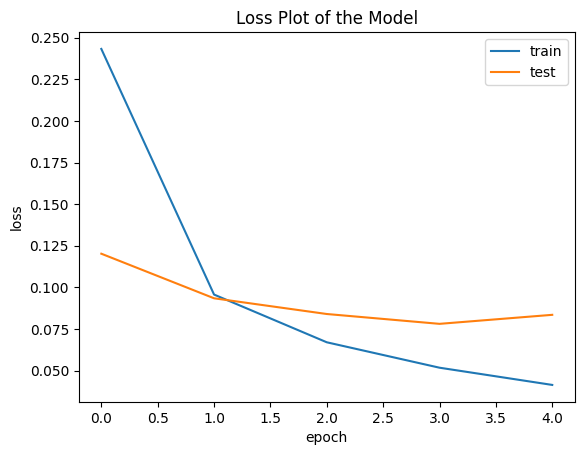

In [61]:
param = 50
num_neurons = [256,64]
for optimizer in [Adam(learning_rate=0.001),RMSprop(learning_rate=0.001)]:
    DenseNN(X_train_pca, y_train, X_test_pca, y_test, num_neurons, optimizer, param)

In [62]:
def DenseNN1(X_train, y_train, X_test, y_test, layer, optimizer, param):

    start_time = time.time()
    #Defining the Model
    model = Sequential([
        Dense(layer[0],activation='relu',input_shape = (param,)),
        Dense(layer[1],activation='sigmoid'),
        Dense(layer[2],activation='relu'),
        Dense(10,activation='softmax')
    ])

    #Compiling the Model with Hyper Parameters.
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    #Summarizing the Model
    #model.summary()

    #Training the Model with the dataset.
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

    #Evaluate the Model and accuracy
    _,acc = model.evaluate(X_test,y_test)
    print("Accuracy of the Model is: ",acc)

    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    precision = precision_score(y_test, y_pred_labels, average= 'macro')
    print("Precision of the Model is: ",precision)


    end_time = time.time()
    print("The time taken for the model execution is :",(end_time-start_time))

    graph_plot(history)

Original Dimensions
438/438 [==============================] - 1s 2ms/step - loss: 0.1700 - accuracy: 0.9536
Accuracy of the Model is:  0.9535714387893677
438/438 [==============================] - 1s 2ms/step
Precision of the Model is:  0.9538810274930285
The time taken for the model execution is : 24.97773790359497


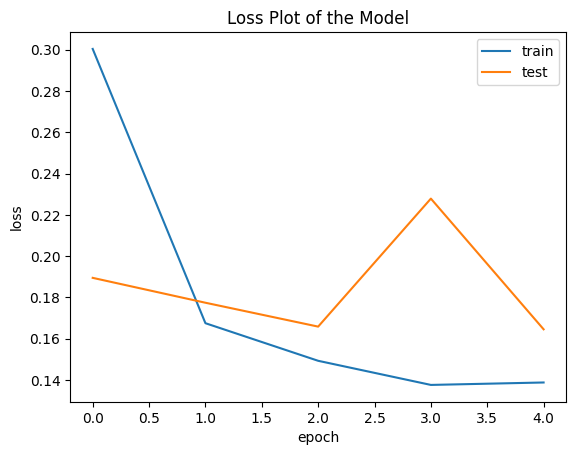

In [63]:
print("Original Dimensions")
param = 784
num_neurons = [128,64,32]
optimizer = Adam(learning_rate=0.01)
DenseNN1(X_train, y_train, X_test, y_test, num_neurons, optimizer, param)

Reduced Dimensions
438/438 [==============================] - 1s 2ms/step - loss: 0.1416 - accuracy: 0.9614
Accuracy of the Model is:  0.9614285826683044
438/438 [==============================] - 1s 2ms/step
Precision of the Model is:  0.9612784861950002
The time taken for the model execution is : 23.84714698791504


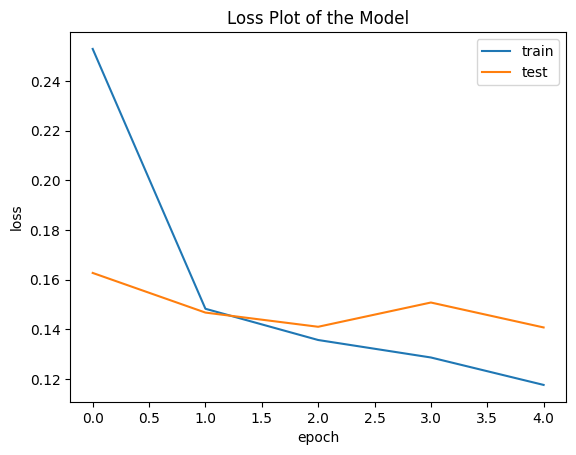

In [64]:
print("Reduced Dimensions")
param = 50
num_neurons = [128,64,32]
optimizer = Adam(learning_rate=0.01)
DenseNN1(X_train_pca, y_train, X_test_pca, y_test, num_neurons, optimizer, param)

-For Neural Network i have used the ADAM and RMSPROP optimizer and learning rates 0.001 for the first model i have neurons as 256 and 64.For the Second model i have the 128 64 and 32 with ADAM and learning is 0.01
-I have Achieved the better accuracy for the first model both in the original and reduced dimensions.
-As the time of execution the logistic classifer with the reduced data set performed in least time with an accuray of 90%.
-But i have achieved the best accuracies in the NN only for the 1st Architecture.
-I conclud that NN has better performance in the reduced dataset of all the architectures in this notebook.